In [152]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA as SklearnPCA
from scipy.linalg import null_space
import numpy as np


In [153]:


# Function to evaluate logistic regression model for a sensitive attribute
def evaluate_sensitive_attribute(df, sensitive_attribute, group_name_str):
    # Separate features (X) and target (y)
    X = df.drop(['pass_bar'], axis=1)  # Drop the target column
    y = df['pass_bar']  # Assuming 'target' is your target column
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Standardize numerical features if necessary
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
    model.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # Print results for the current sensitive attribute
    print(f"\nEvaluation for {sensitive_attribute} - Group: {group_name_str}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity (True Positive Rate): {sensitivity}")
    print(f"Specificity (True Negative Rate): {specificity}")
    print(f"False Negative Rate: {fnr}")
    
    # Print classification report for more detailed metrics
    print(f"\nClassification Report for {sensitive_attribute} - Group: {group_name_str}")
    print(classification_report(y_test, y_pred))
    
    # Store results in a structured format
    results = {
        'Attribute': sensitive_attribute,
        'Group': group_name_str,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'FNR': fnr
    }
    
    return results


In [154]:
# Load  dataset 
df = pd.read_csv('data/scaled_data.csv')

# Map column names to readable group names
race1_map = {
    'race1_asian': 'Asian',
    'race1_black': 'Black',
    'race1_hisp': 'Hisp',
    'race1_other': 'Other',
    'race1_white': 'White'
}

gender_map = {
    1: 'Male',
    0: 'Female'
}

# Group data by sensitive attribute and evaluate for each group
sensitive_attributes = ['race1', 'gender']
results = []

for sensitive_attribute in sensitive_attributes:
    print(f"\nSensitive Attribute: {sensitive_attribute}")
    
    # Evaluate logistic regression model for each subgroup
    if sensitive_attribute == 'race1':
        # For race1, iterate over each race category
        for col in ['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']:
            group_name_str = race1_map[col]
            group_df = df[df[col] == 1.0]  # Filter rows where the race1 category is 1.0 (True)
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)
    else:
        # For gender, iterate over each gender category
        for group_name, group_name_str in gender_map.items():
            group_df = df[df['gender'] == group_name]  # Filter rows where gender matches the current category
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)

# Display results for each subgroup within each sensitive attribute
print("\nSummary of Results:")
for result in results:
    print(result)



Sensitive Attribute: race1

Evaluation for race1 - Group: Asian
Accuracy: 0.7388888888888889
Sensitivity (True Positive Rate): 0.7391304347826086
Specificity (True Negative Rate): 0.7368421052631579
False Negative Rate: 0.2608695652173913

Classification Report for race1 - Group: Asian
              precision    recall  f1-score   support

           0       0.25      0.74      0.37        19
           1       0.96      0.74      0.84       161

    accuracy                           0.74       180
   macro avg       0.60      0.74      0.60       180
weighted avg       0.88      0.74      0.79       180


Evaluation for race1 - Group: Black
Accuracy: 0.6654275092936803
Sensitivity (True Positive Rate): 0.6390243902439025
Specificity (True Negative Rate): 0.75
False Negative Rate: 0.36097560975609755

Classification Report for race1 - Group: Black
              precision    recall  f1-score   support

           0       0.39      0.75      0.52        64
           1       0.89      

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_80874/1595281560.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_80874/1595281560.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_80874/1595281560.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
/

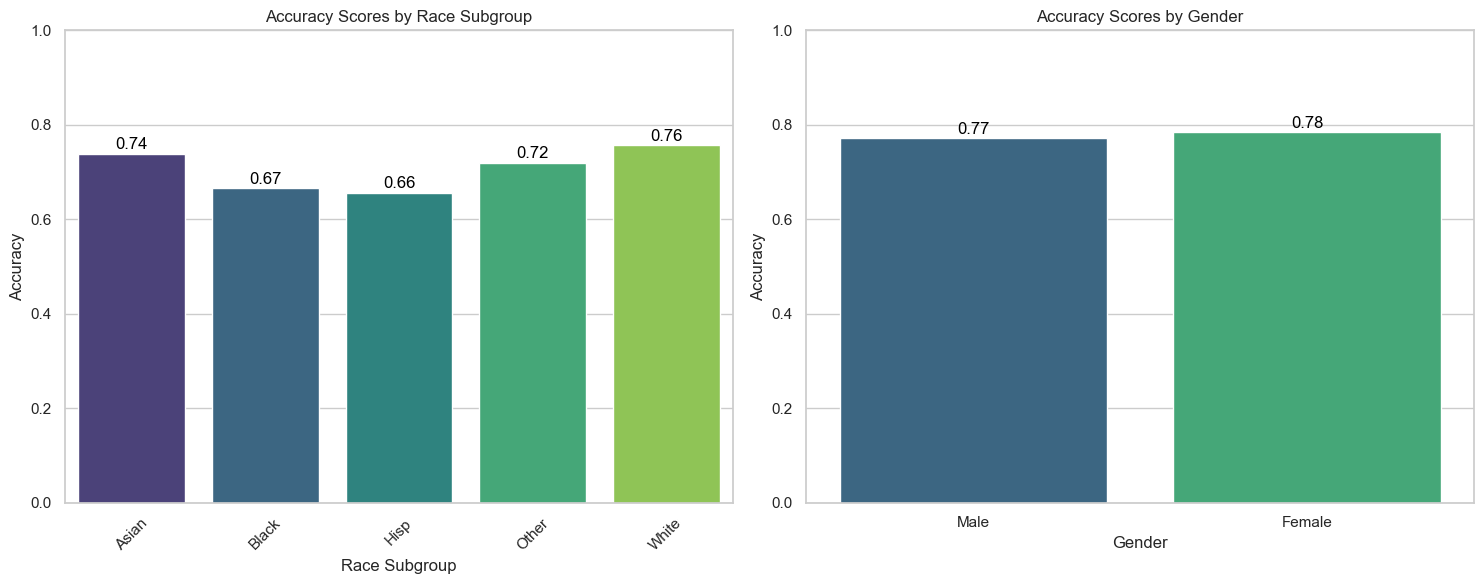

In [155]:
# Extract accuracy scores for each race subgroup
race_subgroups = [result['Group'] for result in results if result['Attribute'] == 'race1']
race_accuracy_scores = [result['Accuracy'] for result in results if result['Attribute'] == 'race1']

# Extract accuracy scores for each gender subgroup
gender_subgroups = [result['Group'] for result in results if result['Attribute'] == 'gender']
gender_accuracy_scores = [result['Accuracy'] for result in results if result['Attribute'] == 'gender']

# Create a DataFrame for plotting race accuracy
race_accuracy_df = pd.DataFrame({'Race Subgroup': race_subgroups, 'Accuracy': race_accuracy_scores})

# Create a DataFrame for plotting gender accuracy
gender_accuracy_df = pd.DataFrame({'Gender Subgroup': gender_subgroups, 'Accuracy': gender_accuracy_scores})

# Set plot style
sns.set(style="whitegrid")

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

# Plot for race accuracy scores
sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
ax1.set_title('Accuracy Scores by Race Subgroup')
ax1.set_xlabel('Race Subgroup')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Annotate race accuracy scores on bars
for index, row in race_accuracy_df.iterrows():
    ax1.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Plot for gender accuracy scores
sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
ax2.set_title('Accuracy Scores by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax2.set_xticklabels(ax2.get_xticklabels())

# Annotate gender accuracy scores on bars
for index, row in gender_accuracy_df.iterrows():
    ax2.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [156]:
from sklearn.model_selection import train_test_split



def preprocess_and_split_data(df, scale):
    # Define features and target
    features = df.drop('pass_bar', axis=1)  # Drop the target column to get features
    target = df['pass_bar']

    # Define groups (race and gender)
    groups = df[['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'gender']]

    # Drop unnecessary columns from features
    features.drop(['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'gender'], axis=1, inplace=True)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, target, groups, test_size=0.3, random_state=0, shuffle=True
    )

    if scale:
        # Standardize numerical features if necessary
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        

    return X_train, X_test, y_train, y_test, group_train, group_test


df = pd.read_csv('data/non_scaled_data.csv')
# Preprocess and split data
X_train, X_test, y_train, y_test, group_train, group_test = preprocess_and_split_data(df, scale=True)

# Printing the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("group_train shape:", group_train.shape)
print("group_test shape:", group_test.shape)

X_train shape: (15684, 11)
X_test shape: (6723, 11)
y_train shape: (15684,)
y_test shape: (6723,)
group_train shape: (15684, 5)
group_test shape: (6723, 5)


In [157]:



def PCA(X_train, n_components):
    """ Implements sci-kit's version of basic PCA and returns sorted eigenvectors"""
    
    pca = SklearnPCA(n_components=n_components)
    X_PCA = pca.fit_transform(X_train)
    
    # Get the sorted eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Reverse order to get descending
    sorted_eig_vectors = eigenvectors[sorted_indices]
    
    return X_PCA, sorted_eig_vectors


def fair_PCA(X_train, groups, n_components=None):
    """Implements fair PCA ensuring components are orthogonal to protected features."""
    
    X = X_train
    Z = groups.astype(int)
    
    # Compute Z.T @ X
    ZTX = np.dot(Z.T, X)
    
    # Compute null space of ZTX
    R = null_space(ZTX)

    
    # Dimension of the null space
    null_space_dim = R.shape[0]
    
    # Compute R.T @ X.T @ X @ R
    RTXXR = np.dot(np.dot(R.T, np.dot(X.T, X)), R)

    # Perform eigen decomposition on RTXXR
    eig_vals, eig_vectors = np.linalg.eig(RTXXR)


    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eig_vectors = eig_vectors[:, sorted_indices]
    
    # Select the top k eigenvectors
    top_k_eig_vectors = sorted_eig_vectors[:, :15]


    # Compute matrix U which is R @ top_k_eig_vectors
    U = np.dot(R, top_k_eig_vectors)

    # Project X onto U to get the Fair PCA components
    X_fair_PCA = np.dot(X, U)

    
    return X_fair_PCA, U

fair_PCA_data = fair_PCA(X_train, group_train)



In [158]:

def corr_plot(X_train, groups, n_components=6, fair=True):
    """Plots the correlation between PCA components and protected features"""
    
    protected_features = groups 
    fig, axes = plt.subplots(figsize=(25, 5))

    if fair:
        # Get the fairPCA transformed data
        X_PCA_n, U = fair_PCA(X_train, groups, n_components)
    else:
        # Get the PCA transformed data
        X_PCA_n, sorted_eigen = PCA(X_train, n_components)

    protected_features = protected_features.astype(int)

    # Compute correlation between PCA components and protected features
    corr_matrix = np.corrcoef(np.column_stack((protected_features, X_PCA_n)).T)

    # Display only the correlation between PCA components and protected features
    corr_matrix = np.nan_to_num(corr_matrix[:protected_features.shape[1], protected_features.shape[1]:], nan=0.0)

    # Determine the range for x-axis labels based on the length of corr_matrix
    x_labels_range = range(1, corr_matrix.shape[1] + 1)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-.1, vmax=.1, square=True, ax=axes, fmt=".2f")
    if fair:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between Fair PCA and Prot. features")
    else:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between PCA and Prot. features")

    axes.set_yticklabels(['Asian', 'Black', 'Hispanic', 'Other', 'Gender'], va='center')
    axes.set_xlabel("Component")
    axes.set_ylabel("Protected Feature (Subgroup)")

    plt.tight_layout()
    plt.show()


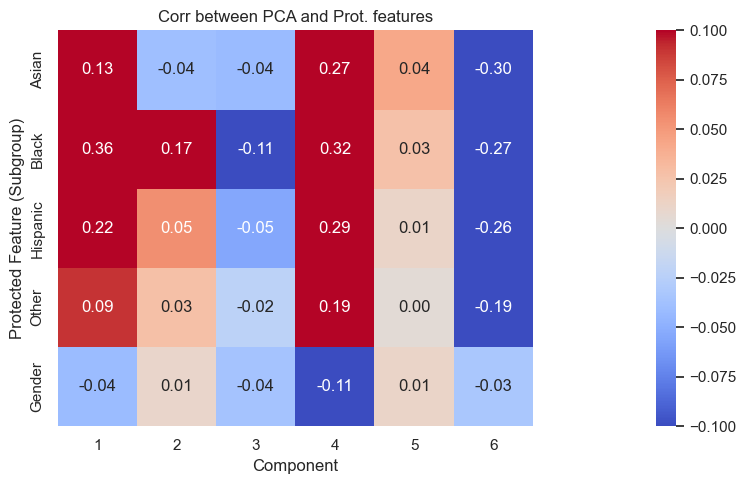

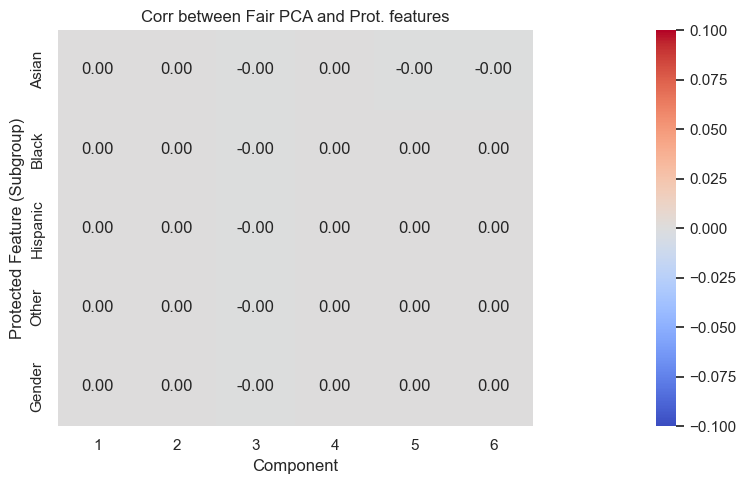

In [159]:
corr_plot(X_train, group_train, fair=False)
corr_plot(X_train, group_train, fair=True)

In [160]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Get PCA components
X_train_PCA, sorted_eig_vectors = PCA(X_train, X_train.shape[1])
X_test_PCA = X_test @ sorted_eig_vectors

# Get debiased data
X_train_fair_PCA, U = fair_PCA(X_train, group_train)
X_test_fair_PCA = X_test @ U

# Logistic Regression model on non-transformed data
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Logistic Regression model on PCA transformed data
lr_pca = LogisticRegression(max_iter=1000, random_state=42)
lr_pca.fit(X_train_PCA, y_train)
y_pred_pca_lr = lr_pca.predict(X_test_PCA)
accuracy_pca_lr = accuracy_score(y_test, y_pred_pca_lr)
f1_pca_lr = f1_score(y_test, y_pred_pca_lr)

# Logistic Regression model on debiased data
lr_fair_pca = LogisticRegression(max_iter=1000, random_state=42)
lr_fair_pca.fit(X_train_fair_PCA, y_train)
y_pred_fair_pca_lr = lr_fair_pca.predict(X_test_fair_PCA)
accuracy_fair_pca_lr = accuracy_score(y_test, y_pred_fair_pca_lr)
f1_fair_pca_lr = f1_score(y_test, y_pred_fair_pca_lr)

print("Accuracy for non-transformed data (Logistic Regression):", round(accuracy_lr, 2))
print("Accuracy for PCA transformed data (Logistic Regression):", round(accuracy_pca_lr, 2))
print("Accuracy for fairPCA transformed data (Logistic Regression):", round(accuracy_fair_pca_lr, 2))

print("F1 score for non-transformed data (Logistic Regression):", round(f1_lr, 2))
print("F1 score for PCA transformed data (Logistic Regression):", round(f1_pca_lr, 2))
print("F1 score for fairPCA transformed data (Logistic Regression):", round(f1_fair_pca_lr, 2))


Accuracy for non-transformed data (Logistic Regression): 0.95
Accuracy for PCA transformed data (Logistic Regression): 0.95
Accuracy for fairPCA transformed data (Logistic Regression): 0.95
F1 score for non-transformed data (Logistic Regression): 0.97
F1 score for PCA transformed data (Logistic Regression): 0.97
F1 score for fairPCA transformed data (Logistic Regression): 0.97


In [171]:


X_train_non_scaled, X_test_non_scaled, y_train_non_scaled, y_test_non_scaled, group_train_non_scaled, group_test_non_scaled = preprocess_and_split_data(df, scale=False)


In [172]:
X_test_male = X_test_non_scaled.loc[group_test_non_scaled['gender'] == 1]
y_test_male = y_test_non_scaled.loc[group_test_non_scaled['gender'] == 1]


X_test_female = X_test_non_scaled.loc[group_test_non_scaled['gender'] == 0]
y_test_female = y_test_non_scaled.loc[group_test_non_scaled['gender'] == 0]


In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming PCA and fair_PCA functions are already defined
# and X_train, X_test, y_train, y_test, group_train, group_test are already preprocessed and split

# Get PCA components
X_train_scaled_PCA, sorted_eig_vectors = PCA(X_train, X_train.shape[1])
X_test_scaled_PCA = X_test @ sorted_eig_vectors

# Get debiased data
X_train_fair_PCA, U = fair_PCA(X_train, group_train)
X_test_fair_PCA = X_test @ U

# Step 2: Train the Logistic Regression model on PCA-transformed data
fair_model = LogisticRegression()
fair_model.fit(X_train_fair_PCA, y_train)

# Step 3: Predict labels for the test set
y_pred = fair_model.predict(X_test_fair_PCA)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Apply PCA transformation to X_test_male
X_test_male_PCA = X_test_male @ U

# Predict labels for men
y_pred_men = fair_model.predict(X_test_male_PCA)

# Calculate accuracy for men
accuracy_men = accuracy_score(y_test_male, y_pred_men)
print("Accuracy for men:", accuracy_men)

# Apply PCA transformation to X_test_female
X_test_female_PCA = X_test_female @ U

# Predict labels for women
y_pred_women = fair_model.predict(X_test_female_PCA)

# Calculate accuracy for women
accuracy_women = accuracy_score(y_test_female, y_pred_women)
print("Accuracy for women:", accuracy_women)


Accuracy: 0.9461549903316971
Accuracy for men: 0.9551181102362205
Accuracy for women: 0.9347751458976999


In [164]:
# Sanity check to make sure we are using the correct observations
print(X_test_fair_PCA.shape[0] == X_test.shape[0])

True


In [ ]:

# Train a logistic regression model using the standardized data that has not been pca transformed
standard_model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
standard_model.fit(X_train, y_train)



In [186]:


# Ensure group_test_non_scaled is converted to a NumPy array if it's not already
group_test_non_scaled = np.array(group_test_non_scaled)

# Get indices for rows with gender == 0
gender_zero_indices = np.where(group_test_non_scaled[:, -1] == 0)[0]

# Filter data by gender_zero_indices
filtered_data = X_test[gender_zero_indices]

print(filtered_data.shape)
# Step 4: Calculate the predicted probabilities for these data points
probabilities = standard_model.predict_proba(filtered_data)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

# Create a structured array to hold the filtered data and the probabilities
filtered_data_with_probs = np.column_stack((filtered_data, probabilities, prob_diff))

# Define column names for the structured array
column_names = [f'feature_{i}' for i in range(filtered_data.shape[1])] + ['prob_class_0', 'prob_class_1', 'prob_diff']

# Convert the structured array to a pandas DataFrame for easier sorting
filtered_data_df = pd.DataFrame(filtered_data_with_probs, columns=column_names)

# Step 5: Sort the data by the absolute difference between the class probabilities in ascending order
sorted_filtered_data = filtered_data_df.sort_values(by='prob_diff')

# Output the top 10 data points where the probabilities are most balanced
top_10_balanced = sorted_filtered_data.head(10)

# Display the probabilities for the top 10 balanced data points
for index, row in top_10_balanced.iterrows():
    print(f"Index: {index}, Probabilities: Class 0 = {row['prob_class_0']}, Class 1 = {row['prob_class_1']}")


(2913, 11)
Index: 1571, Probabilities: Class 0 = 0.5003732699752692, Class 1 = 0.49962673002473085
Index: 1152, Probabilities: Class 0 = 0.4993747065267755, Class 1 = 0.5006252934732245
Index: 2508, Probabilities: Class 0 = 0.4992600789339776, Class 1 = 0.5007399210660224
Index: 2485, Probabilities: Class 0 = 0.4991817189130088, Class 1 = 0.5008182810869912
Index: 1195, Probabilities: Class 0 = 0.5009692344301936, Class 1 = 0.4990307655698064
Index: 2107, Probabilities: Class 0 = 0.4987112067257382, Class 1 = 0.5012887932742618
Index: 1581, Probabilities: Class 0 = 0.5018423619152201, Class 1 = 0.4981576380847798
Index: 1211, Probabilities: Class 0 = 0.5018509268278413, Class 1 = 0.49814907317215873
Index: 2479, Probabilities: Class 0 = 0.5019549136870782, Class 1 = 0.4980450863129217
Index: 1482, Probabilities: Class 0 = 0.4979166599050685, Class 1 = 0.5020833400949315


In [194]:
X_test_female

,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,fam_inc,tier,race1_white,grad,fulltime
10988,5.0,2.0,6.0,25.0,2.9,65.0,3.0,1.0,0.0,1.0,1.0
10516,7.0,8.0,7.0,42.0,2.9,61.0,2.0,1.0,1.0,1.0,1.0
927,3.0,3.0,4.0,33.0,3.5,57.0,2.0,3.0,0.0,1.0,2.0
6836,7.0,7.0,7.0,36.0,3.2,38.0,3.0,3.0,1.0,1.0,1.0
14615,9.0,7.0,9.0,37.0,3.7,63.0,4.0,4.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8720,10.0,10.0,10.0,44.0,3.6,69.0,4.0,4.0,1.0,1.0,1.0
766,3.0,6.0,3.0,35.0,3.5,60.0,4.0,3.0,1.0,1.0,1.0
11987,1.0,1.0,1.0,32.0,2.8,54.0,3.0,3.0,1.0,1.0,1.0
14147,6.0,6.0,6.0,40.0,3.7,69.0,3.0,3.0,1.0,1.0,1.0


In [193]:
for i in top_10_balanced.index:

    print(X_test_female.head())
    # Extract the ith observation from the X_test that only consists of the female observations
    observation = X_test_female[i]

    # Reshape the observation to match the expected input shape for prediction
    observation = observation.reshape(1, -1)  # Reshape to (1, n_features) if necessary

    # Predict probabilities using the trained standard model
    probabilities_standard = standard_model.predict_proba(observation)

    # Print the probabilities for each class for the standard model
    print(f"Probabilities for observation {i} in the standardize non-transformed dataset: Class 0 = {probabilities_standard[0, 0]}, Class 1 = {probabilities_standard[0, 1]}")

    # Extract the ith observation from X_test_fair_PCA
    observation_fairPCA = X_test_fair_PCA[i]

    # Reshape the observation to match the expected input shape for prediction
    observation_fairPCA = observation_fairPCA.reshape(1, -1)  # Reshape to (1, n_features) if necessary

    # Predict probabilities using the trained fair model
    probabilities_fairPCA = fair_model.predict_proba(observation_fairPCA)

    # Print the probabilities for each class for the fair model
    print(f"Probabilities for observation {i} in the fairPCA transformed dataset: Class 0 = {probabilities_fairPCA[0, 0]}, Class 1 = {probabilities_fairPCA[0, 1]}")
    print('\n')


       decile1b  decile3  decile1  lsat  ugpa  DOB_yr  fam_inc  tier  \
10988       5.0      2.0      6.0  25.0   2.9    65.0      3.0   1.0   
10516       7.0      8.0      7.0  42.0   2.9    61.0      2.0   1.0   
927         3.0      3.0      4.0  33.0   3.5    57.0      2.0   3.0   
6836        7.0      7.0      7.0  36.0   3.2    38.0      3.0   3.0   
14615       9.0      7.0      9.0  37.0   3.7    63.0      4.0   4.0   

       race1_white  grad  fulltime  
10988          0.0   1.0       1.0  
10516          1.0   1.0       1.0  
927            0.0   1.0       2.0  
6836           1.0   1.0       1.0  
14615          1.0   1.0       1.0  


KeyError: 1571